# Forecasting - Facebook Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [38]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [4]:

#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet 

In [5]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)

In [7]:
# the final trivial model is at the end of this file

df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [8]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [9]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

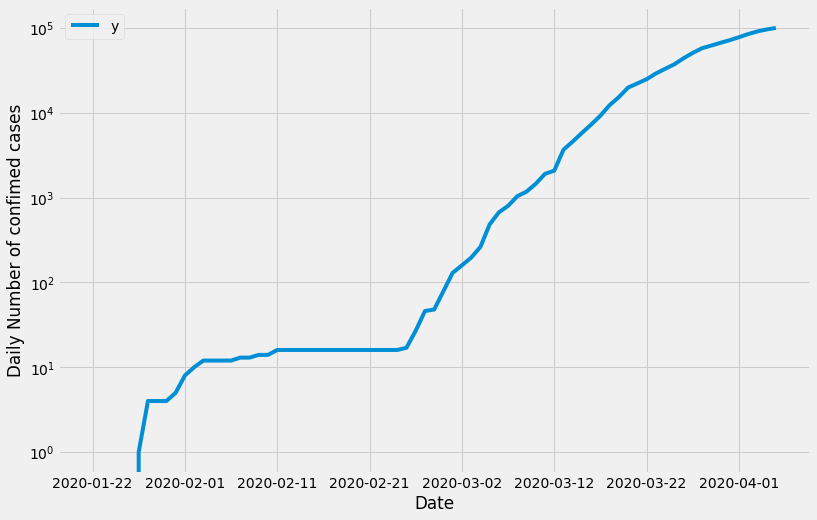

In [10]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()


In [47]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#my_model = Prophet(interval_width=0.95) # piecwise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [48]:
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.
my_model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/kienlef/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [50]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
77,2020-04-08,1000000.0
78,2020-04-09,1000000.0
79,2020-04-10,1000000.0
80,2020-04-11,1000000.0
81,2020-04-12,1000000.0


In [51]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)

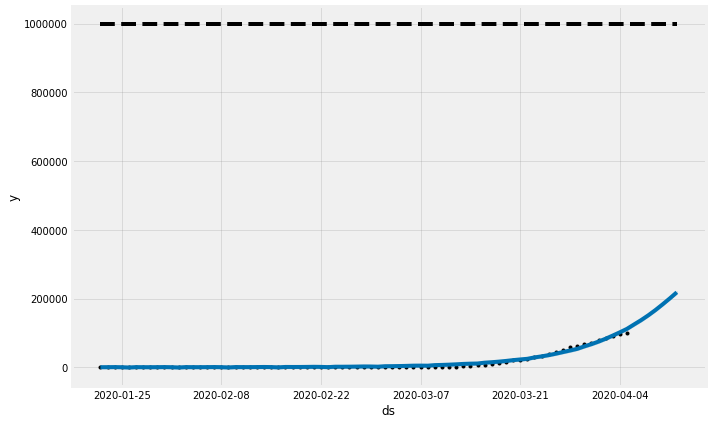

In [52]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [53]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [54]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,29.024749,1000000.0,-4147.009656,4374.156062,29.024749,29.024749,40.425749,40.425749,40.425749,40.425749,40.425749,40.425749,0.0,0.0,0.0,69.450497
1,2020-01-23,32.505586,1000000.0,-4367.361924,4605.010584,32.505586,32.505586,145.765627,145.765627,145.765627,145.765627,145.765627,145.765627,0.0,0.0,0.0,178.271213
2,2020-01-24,36.403853,1000000.0,-3964.908160,4647.491978,36.403853,36.403853,342.535003,342.535003,342.535003,342.535003,342.535003,342.535003,0.0,0.0,0.0,378.938856
3,2020-01-25,40.769604,1000000.0,-4210.144070,4386.733981,40.769604,40.769604,-28.073419,-28.073419,-28.073419,-28.073419,-28.073419,-28.073419,0.0,0.0,0.0,12.696185
4,2020-01-26,45.658897,1000000.0,-5233.923440,3896.471215,45.658897,45.658897,-814.950570,-814.950570,-814.950570,-814.950570,-814.950570,-814.950570,0.0,0.0,0.0,-769.291672


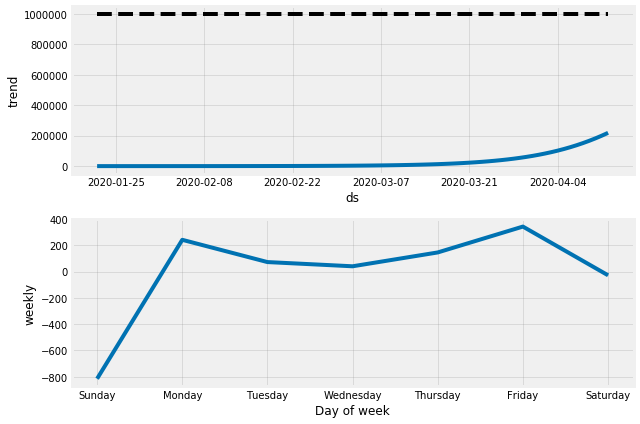

In [55]:
my_model.plot_components(forecast);

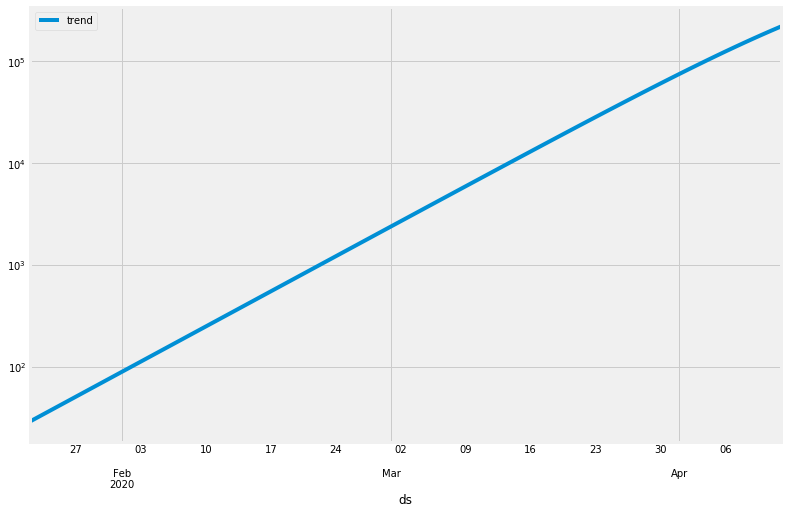

In [56]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross-Validation

In [75]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

INFO:fbprophet:Making 28 forecasts with cutoffs between 2020-03-02 00:00:00 and 2020-03-29 00:00:00
/Users/kienlef/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [76]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,-1.394040,-39.890079,43.565468,196,2020-03-02
1,2020-03-04,-2.115313,-44.818734,40.700973,262,2020-03-02
2,2020-03-05,1.280726,-44.148178,43.967962,482,2020-03-02
3,2020-03-06,2.171446,-39.640079,49.061481,670,2020-03-02
4,2020-03-07,8.055175,-36.369678,51.319176,799,2020-03-02


In [77]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [78]:
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.104050e+07,3322.724439,2001.669144,0.178623,0.132231,0.035714
1,2 days,3.599883e+07,5999.902679,3701.434783,0.238237,0.190665,0.035714
2,3 days,9.042618e+07,9509.267991,6075.096296,0.306168,0.253955,0.035714
3,4 days,1.961781e+08,14006.359095,9238.480765,0.381395,0.346233,0.000000
4,5 days,3.922768e+08,19805.978903,13453.862771,0.458933,0.420061,0.000000
5,6 days,7.430179e+08,27258.354439,18994.558591,0.554278,0.554946,0.000000
6,7 days,1.346240e+09,36691.146926,26138.951678,0.659315,0.692649,0.000000


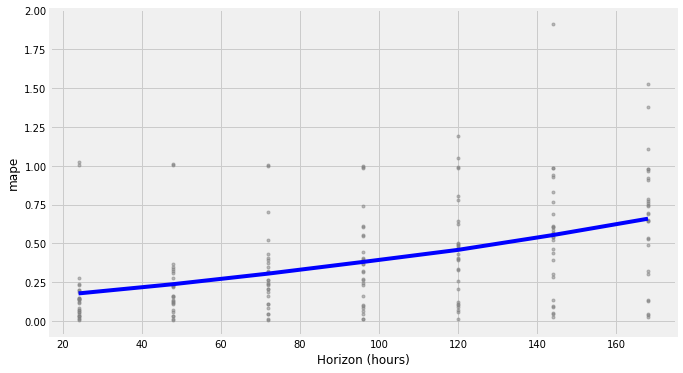

In [79]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot 

### gives a good understanding for the under and over estimation w.r.t. magnitude 

In [80]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [81]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
167,2020-04-01,128146.729821,127143.751523,129188.116770,77872,2020-03-25,7 days
174,2020-04-02,139873.624245,138766.776879,141042.513747,84794,2020-03-26,7 days
181,2020-04-03,153750.928370,152515.969097,154939.840459,91159,2020-03-27,7 days
188,2020-04-04,167905.292077,166698.469691,169123.573128,96092,2020-03-28,7 days
195,2020-04-05,176112.176913,174684.403861,177581.737274,100123,2020-03-29,7 days


In [82]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

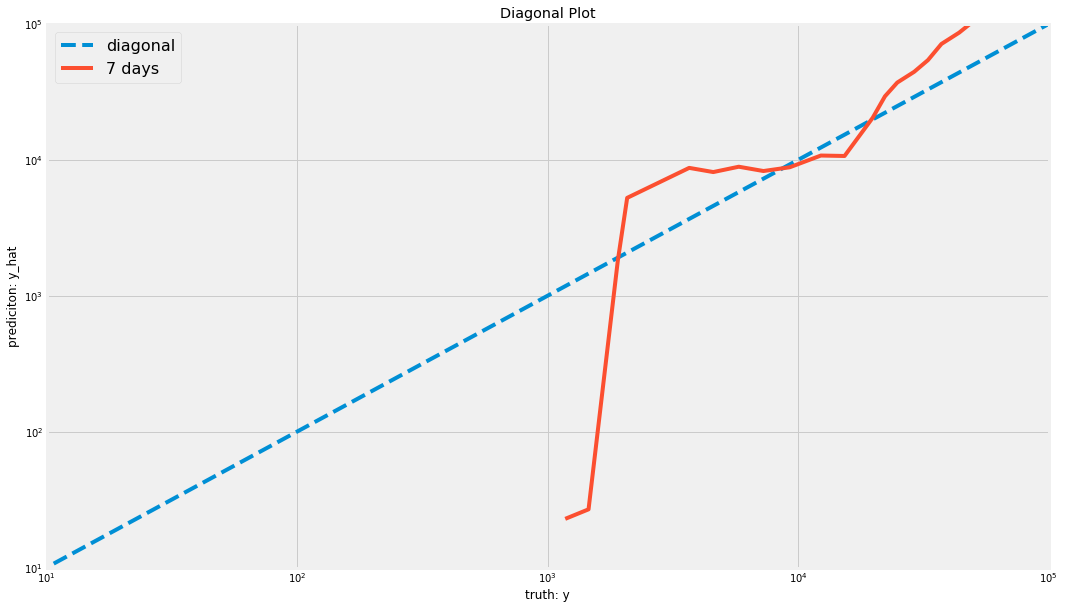

In [83]:

fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

 Example trivial forecast, prediciton 7 days into the future

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [95]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean 

An other standard forecast is the exponentially-weighted moving average,
see pandas.ewma

In [97]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [98]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 437.62995837158184


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
